# **Praktikum 10 - Recurrent Neural Network (RNN)**

Nama : Alfan Olivan

NIM : 2141720078

## **Praktikum 1**

* Setup

In [1]:
# Setup
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

* Setup Input Pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

* Mencetak label dan text dari dataset train

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


*  Acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Some things need to be clarified. The picture of Mark Ferris is not the Mark Ferris who starred in this movie. I know that because he was my dad. Please remove that picture. Also, Mark Ferris was the writer, at least one of them. I have been trying to find a copy or a way to see this movie again. It has been years and if someone can point me in the direction of obtaining a copy, that would be great. The movie wasn't all that bad, and trying to compare it to todays world of Star Wars and other high tech sci fi's it futile. If you watch it, just enjoy it for the rediculousness and humor it possesses. Lighten up on being movie snobs and enjoy some less creative and innovated films."
 b'ORCA is not exactly bad, but it\'s not really Richard Harris\'s finest hour either. As a demented, Ahab-like fisherman, Harris gets into a game of death with a vengeful killer whale after killing the whale\'s "wife" and unborn child. Charlotte Rampling plays a whale expert who gets involved with 

* Buat Teks Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 47, 180, 341, ...,   0,   0,   0],
       [  1,   7,  22, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

* Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

* Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Some things need to be clarified. The picture of Mark Ferris is not the Mark Ferris who starred in this movie. I know that because he was my dad. Please remove that picture. Also, Mark Ferris was the writer, at least one of them. I have been trying to find a copy or a way to see this movie again. It has been years and if someone can point me in the direction of obtaining a copy, that would be great. The movie wasn't all that bad, and trying to compare it to todays world of Star Wars and other high tech sci fi's it futile. If you watch it, just enjoy it for the rediculousness and humor it possesses. Lighten up on being movie snobs and enjoy some less creative and innovated films."
Round-trip:  some things need to be [UNK] the picture of mark [UNK] is not the mark [UNK] who [UNK] in this movie i know that because he was my [UNK] please [UNK] that picture also mark [UNK] was the writer at least one of them i have been trying to find a [UNK] or a way to see this movie again it

* Buat Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.00718092]


In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

* Train Model

In [14]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 98ms/step - loss: 0.6373 - accuracy: 0.5739 - val_loss: 0.4901 - val_accuracy: 0.7495
Epoch 2/10
391/391 [==============================] - 24s 60ms/step - loss: 0.4034 - accuracy: 0.8166 - val_loss: 0.3681 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3444 - accuracy: 0.8503 - val_loss: 0.3708 - val_accuracy: 0.8219
Epoch 4/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3259 - accuracy: 0.8597 - val_loss: 0.3368 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3168 - accuracy: 0.8642 - val_loss: 0.3269 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3098 - accuracy: 0.8689 - val_loss: 0.3315 - val_accuracy: 0.8490
Epoch 7/10
391/391 [==============================] - 23s 58ms/step - loss: 0.3029 - accuracy: 0.8714 - val_loss: 0.3213 - val_accuracy:

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 32ms/step - loss: 0.3160 - accuracy: 0.8565
Test Loss: 0.31595420837402344
Test Accuracy: 0.8564800024032593


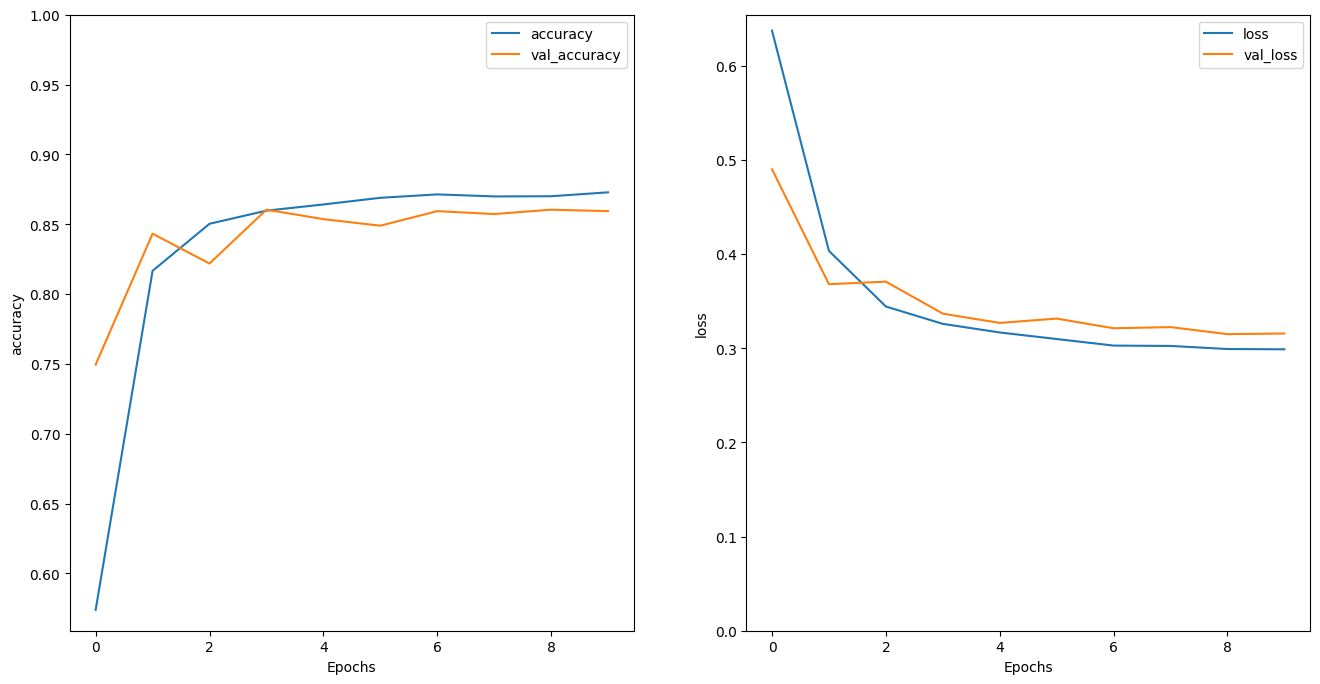

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


* Stack two or more LSTM layers

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                     validation_data=test_dataset,
                     validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 148ms/step - loss: 0.5983 - accuracy: 0.6183 - val_loss: 0.4547 - val_accuracy: 0.7594
Epoch 2/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3765 - accuracy: 0.8359 - val_loss: 0.4084 - val_accuracy: 0.8250
Epoch 3/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3381 - accuracy: 0.8537 - val_loss: 0.3308 - val_accuracy: 0.8599
Epoch 4/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3206 - accuracy: 0.8661 - val_loss: 0.3256 - val_accuracy: 0.8625
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3145 - accuracy: 0.8661 - val_loss: 0.3235 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3059 - accuracy: 0.8712 - val_loss: 0.3282 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3055 - accuracy: 0.8694 - val_loss: 0.3189 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3324 - accuracy: 0.8599
Test Loss: 0.3324196934700012
Test Accuracy: 0.8599200248718262


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0072489]]


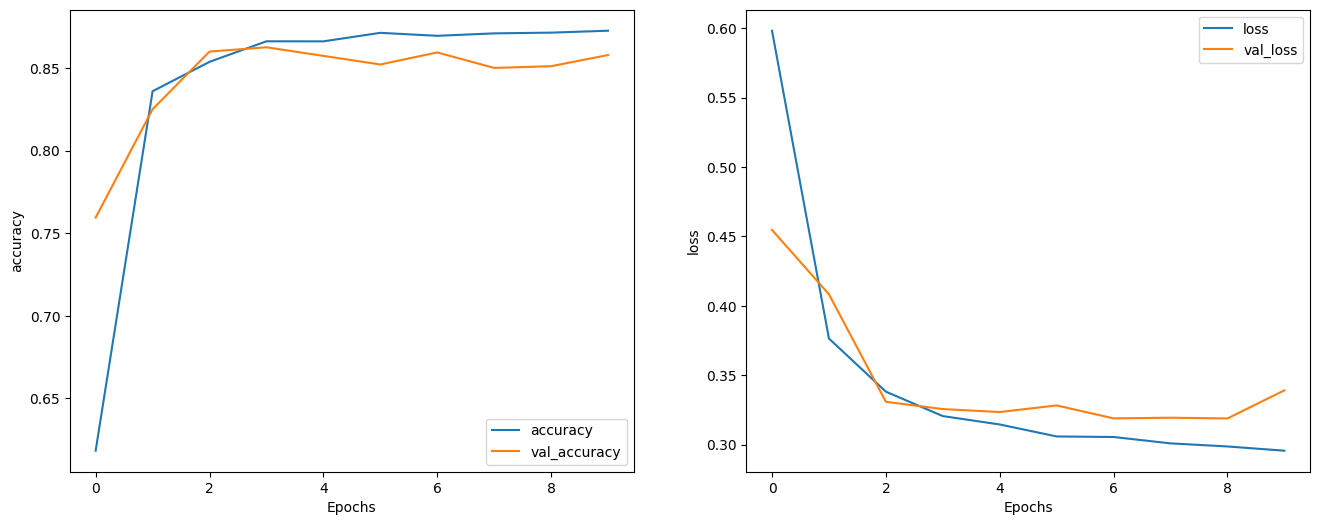

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.show()